# This model under samples the non failure metrics to account for the imbalance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import (accuracy_score, 
                             precision_score, 
                             recall_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay,
                             f1_score,
                             roc_curve,
                             auc)
from imblearn.under_sampling import RandomUnderSampler

#### Loading initial data

In [2]:
initial_data = pd.read_csv('../data/ai4i2020.csv')

#### Random Undersampling performed

In [3]:
# Get all non failed rows
non_failures = initial_data[initial_data['Machine failure'] == 0]
non_failures.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
# Get all failed rows
failures = initial_data[initial_data['Machine failure'] == 1]
amnt_failures = len(failures)
print(amnt_failures)
failures["Machine failure"].value_counts()

339


Machine failure
1    339
Name: count, dtype: int64

In [5]:
# Get a random sample of non failures with the same size as amount of failures
undersampled_data = non_failures.sample(n=amnt_failures, replace=False)
print(len(undersampled_data))
undersampled_data["Machine failure"].value_counts()

339


Machine failure
0    339
Name: count, dtype: int64

In [6]:
# Create final dataframe for model to use
undersampled_data = pd.concat([undersampled_data, failures])


In [7]:
# View the distribution of the data
undersampled_data["Machine failure"].value_counts()

Machine failure
0    339
1    339
Name: count, dtype: int64

#### Random undersampling with Imblearn

In [8]:
rus = RandomUnderSampler(random_state=42, replacement=True)

In [9]:
X_resample = initial_data.drop(
    columns=["Machine failure"])
y_resample = initial_data["Machine failure"]
x_rus, y_rus = rus.fit_resample(X_resample, y_resample)


In [10]:
rus_undersampled_data = pd.concat([x_rus, y_rus], axis=1)

#### Convering Type column into binary values for model preperation

In [11]:
dummy = pd.get_dummies(undersampled_data['Type'], dtype=int, drop_first=True)
rs_dummy = pd.get_dummies(
    rus_undersampled_data['Type'], dtype=int, drop_first=True)

In [12]:
cleaned_data = pd.concat([undersampled_data, dummy], axis=1)
rs_cleaned = pd.concat([rus_undersampled_data, rs_dummy], axis=1)

In [13]:
cleaned_data.drop(columns=["Type", "Product ID", "UDI", "TWF", "HDF", "PWF", "OSF", "RNF"], inplace=True)
rs_cleaned.drop(columns=["Type", "Product ID", "UDI",
                  "TWF", "HDF", "PWF", "OSF", "RNF"], inplace=True)

In [14]:
cleaned_data.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,L,M
5308,304.0,313.2,1481,42.6,213,0,1,0
809,296.9,307.6,1452,45.7,122,0,1,0
1931,298.2,308.0,1969,21.7,32,0,0,1
9039,297.3,308.3,1341,51.9,51,0,0,1
3165,300.4,309.6,1536,34.5,154,0,1,0


In [15]:
X = cleaned_data.drop(columns=["Machine failure"])
X

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],L,M
5308,304.0,313.2,1481,42.6,213,1,0
809,296.9,307.6,1452,45.7,122,1,0
1931,298.2,308.0,1969,21.7,32,0,1
9039,297.3,308.3,1341,51.9,51,0,1
3165,300.4,309.6,1536,34.5,154,1,0
...,...,...,...,...,...,...,...
9758,298.6,309.8,2271,16.2,218,1,0
9764,298.5,309.5,1294,66.7,12,1,0
9822,298.5,309.4,1360,60.9,187,1,0
9830,298.3,309.3,1337,56.1,206,1,0


In [16]:
y = cleaned_data["Machine failure"]
y.value_counts()

Machine failure
0    339
1    339
Name: count, dtype: int64

In [17]:
rs_cleaned.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,L,M
7557,300.4,311.5,1750,27.3,116,0,0,1
881,295.7,306.2,1464,46.2,92,0,1,0
5640,302.6,312.1,1420,51.6,182,0,1,0
5436,302.9,312.5,1679,30.9,79,0,0,1
5988,300.7,310.8,1296,58.2,204,0,0,0


In [18]:
X_rs = rs_cleaned.drop(columns=["Machine failure"])
X_rs.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],L,M
7557,300.4,311.5,1750,27.3,116,0,1
881,295.7,306.2,1464,46.2,92,1,0
5640,302.6,312.1,1420,51.6,182,1,0
5436,302.9,312.5,1679,30.9,79,0,1
5988,300.7,310.8,1296,58.2,204,0,0


In [19]:
y_rs = rs_cleaned["Machine failure"]
y_rs.value_counts()

Machine failure
0    339
1    339
Name: count, dtype: int64

#### Creating Logistic Regression Model with random undersamples

In [20]:
log_model = LogisticRegression(max_iter=1000)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

y_test.value_counts()

Machine failure
0    95
1    75
Name: count, dtype: int64

In [21]:
rs_log_model = LogisticRegression(max_iter=1000)
rs_kf = KFold(n_splits=5, shuffle=True, random_state=42)

rs_accuracy_scores = []
rs_precision_scores = []
rs_recall_scores = []
rs_f1_scores = []

RSX_train, RSX_test, rsy_train, rsy_test = train_test_split(
    X_rs, y_rs, test_size=0.25, random_state=42)

rsy_test.value_counts()

Machine failure
0    95
1    75
Name: count, dtype: int64

#### Training Models


In [22]:
# Random undersampled data
for train_set, val_set in kf.split(X_train):
    X_train_split, y_train_split = X_train.iloc[train_set], y_train.iloc[train_set]
    X_val_split, y_val_split = X_train.iloc[val_set], y_train.iloc[val_set]
    log_model.fit(X_train_split, y_train_split)
    model_predictions = log_model.predict(X_val_split)

    accuracy_scores.append(accuracy_score(y_val_split, model_predictions))
    precision_scores.append(precision_score(
        y_val_split, model_predictions))
    recall_scores.append(recall_score(y_val_split, model_predictions))
    f1_scores.append(f1_score(y_val_split, model_predictions))

In [23]:
# Random undersampled data using imblearn
for train_set, val_set in rs_kf.split(RSX_train):
    X_train_split, y_train_split = RSX_train.iloc[train_set], rsy_train.iloc[train_set]
    X_val_split, y_val_split = RSX_train.iloc[val_set], rsy_train.iloc[val_set]
    log_model.fit(X_train_split, y_train_split)
    model_predictions = log_model.predict(X_val_split)

    rs_accuracy_scores.append(accuracy_score(y_val_split, model_predictions))
    rs_precision_scores.append(precision_score(
        y_val_split, model_predictions))
    rs_recall_scores.append(recall_score(y_val_split, model_predictions))
    rs_f1_scores.append(f1_score(y_val_split, model_predictions))

#### Assessing model's performance from splits

In [24]:
# Scores not using imblearn's library
print(f"Average Accuracy Score: {np.mean(accuracy_scores) * 100}")
print(f"Average Precision Score: {np.mean(precision_scores) * 100}")
print(f"Average Recall Score: {np.mean(recall_scores) * 100}")
print(f"Average F1 Score: {np.mean(f1_scores) * 100}")

Average Accuracy Score: 81.49679673849738
Average Precision Score: 82.55443378296945
Average Recall Score: 82.02114962291046
Average F1 Score: 82.19234175828562


In [25]:
# Scores using imblearn's library
print(f"Average RS Accuracy Score: {np.mean(rs_accuracy_scores) * 100}")
print(f"Average RS Precision Score: {np.mean(rs_precision_scores) * 100}")
print(f"Average RS Recall Score: {np.mean(rs_recall_scores) * 100}")
print(f"Average RS F1 Score: {np.mean(rs_f1_scores) * 100}")

Average RS Accuracy Score: 83.661424966026
Average RS Precision Score: 85.28112745098039
Average RS Recall Score: 83.9806882718108
Average RS F1 Score: 84.22888689456364


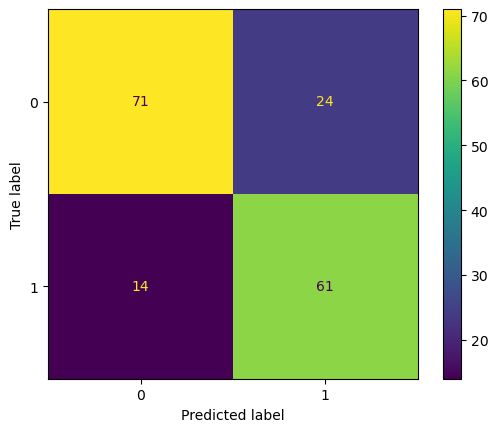

In [26]:
# Confusion Matrix for random undersampled data
log_model.fit(X_train, y_train)
model_predictions = log_model.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, model_predictions)).plot()

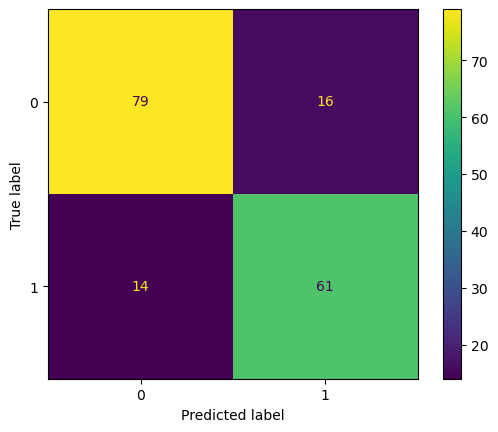

In [27]:
# Confusion Matrix for random undersampled data using imblearn
log_model.fit(RSX_train, rsy_train)
model_predictions = log_model.predict(RSX_test)
ConfusionMatrixDisplay(confusion_matrix(rsy_test, model_predictions)).plot()

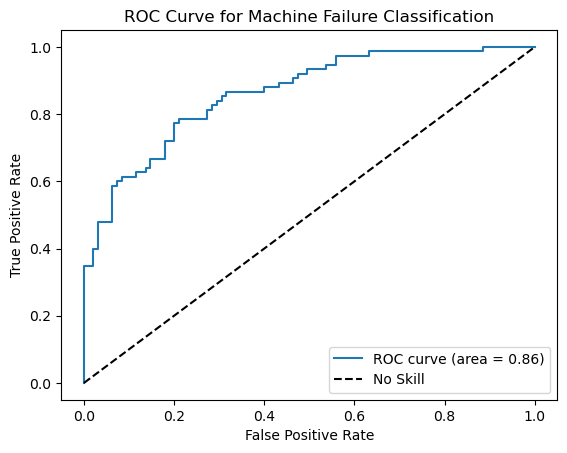

In [28]:
# Plotting the ROC curve for random undersampled data
y_pred_proba = log_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Machine Failure Classification')
plt.legend()
plt.show()

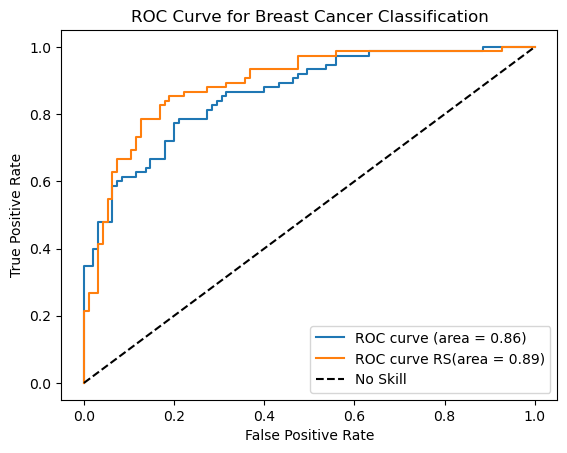

In [29]:
# Plotting the ROC curve for random undersampled data using imblearn
rsy_pred_proba = log_model.predict_proba(RSX_test)[:, 1]

rsfpr, rstpr, thresholds = roc_curve(rsy_test, rsy_pred_proba)

rsroc_auc = auc(rsfpr, rstpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) # Data not using imblearn
plt.plot(rsfpr, rstpr, label='ROC curve RS(area = %0.2f)' % rsroc_auc) # Data using imblearn
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Breast Cancer Classification')
plt.legend()
plt.show()